In [1]:
# Pastikan semua instalasi ada di awal jika diperlukan
!pip install kagglehub --quiet --upgrade
!pip install split-folders --quiet
!pip install scikit-learn --quiet --upgrade
!pip install tqdm tqdm_joblib --quiet

# ==============================================================================
# SECTION 0: IMPORT SEMUA LIBRARY YANG DIBUTUHKAN
# ==============================================================================
# Standard & Data Handling
import os
import shutil
import zipfile
import time
import numpy as np
import pandas as pd
from PIL import Image
import joblib
import re

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Kaggle & Drive
from google.colab import drive
import kagglehub

# Preprocessing & Splitting
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder # LabelEncoder tetap dipakai
import splitfolders

# Model Regresi yang akan dipakai untuk Klasifikasi
from sklearn.ensemble import RandomForestRegressor

# Metrics & Evaluation (Klasifikasi & Regresi untuk perbandingan)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(f"Library siap untuk 'Klasifikasi via RandomForestRegressor'. (Tanggal: {time.strftime('%Y-%m-%d %H:%M:%S')})")
print("PERINGATAN: Menggunakan RandomForestRegressor untuk klasifikasi adalah pendekatan non-standar.")

Library siap untuk 'Klasifikasi via RandomForestRegressor'. (Tanggal: 2025-05-07 17:24:47)
PERINGATAN: Menggunakan RandomForestRegressor untuk klasifikasi adalah pendekatan non-standar.


In [2]:
# ==============================================================================
# SECTION 1: SETUP DAN MOUNT GOOGLE DRIVE (Sama)
# ==============================================================================
print("\n--- SECTION 1: Setup dan Mount Google Drive ---")
try:
    drive.mount('/content/drive')
    print("Google Drive berhasil di-mount.")
except Exception as e: print(f"Error mounting: {e}")

PROJECT_NAME = "ProyekKlasifikasiViaRFR_ulang" # Nama baru agar tidak konflik
BASE_DRIVE_PATH = "/content/drive/MyDrive"
PROJECT_PATH = os.path.join(BASE_DRIVE_PATH, PROJECT_NAME)
DATASET_PATH = os.path.join(PROJECT_PATH, "datasets_cvr_rfr")
RAW_DATA_PATH = os.path.join(DATASET_PATH, "raw_food_img_cvr_rfr")
PROCESSED_DATA_PATH = os.path.join(DATASET_PATH, "processed_cvr_rfr")
MODEL_PATH = os.path.join(PROJECT_PATH, "models_cvr_rfr")
RESULTS_PATH = os.path.join(PROJECT_PATH, "results_cvr_rfr")
for path in [PROJECT_PATH, DATASET_PATH, RAW_DATA_PATH, PROCESSED_DATA_PATH, MODEL_PATH, RESULTS_PATH]:
    os.makedirs(path, exist_ok=True)
print(f"Folder proyek '{PROJECT_NAME}' disiapkan di: {PROJECT_PATH}")


--- SECTION 1: Setup dan Mount Google Drive ---
Mounted at /content/drive
Google Drive berhasil di-mount.
Folder proyek 'ProyekKlasifikasiViaRFR_ulang' disiapkan di: /content/drive/MyDrive/ProyekKlasifikasiViaRFR_ulang


In [3]:
# ==============================================================================
# SECTION 2: DOWNLOAD DATASETS GAMBAR & STAGING (Sama, ambil gambar makanan)
# ==============================================================================
print("\n--- SECTION 2: Unduh Dataset Gambar Makanan ('faldoae/padangfood') ---")
KAGGLE_DATASET_IDENTIFIER = 'faldoae/padangfood'
DATASET_FOLDER_NAME_ON_DRIVE = KAGGLE_DATASET_IDENTIFIER.split('/')[-1] + "_cvr_rfr"
temp_colab_base_path = "/content/kaggle_food_temp_cvr_rfr_ulang" # Area kerja sementara baru
# --- Fungsi Helper find_actual_data_root & display_folder_structure (Sama seperti sebelumnya) ---
def find_actual_data_root(current_path, min_expected_class_folders=2, current_depth=0, max_search_depth=2): # Definisi disingkat
    if not os.path.isdir(current_path) or current_depth > max_search_depth: return current_path
    items = [item for item in os.listdir(current_path) if item not in ['__MACOSX', '.DS_Store', '.ipynb_checkpoints']]
    item_paths = [os.path.join(current_path, item) for item in items]; subdirectories = [p for p in item_paths if os.path.isdir(p)]
    if len(subdirectories) >= min_expected_class_folders: print(f"  [find] Root di '{current_path}'"); return current_path
    if len(subdirectories) == 1 and (len(items) == 1 or all(os.path.isfile(p) for p in item_paths if p != subdirectories[0])):
        print(f"  [find] Masuk ke '{subdirectories[0]}'"); return find_actual_data_root(subdirectories[0], min_expected_class_folders, current_depth + 1, max_search_depth)
    print(f"  [find] Menggunakan '{current_path}'"); return current_path
def display_folder_structure(root_dir, title="Folder Structure", max_depth=1, max_files_per_folder=3): # Definisi disingkat
    print(f"\n--- {title} ({root_dir}) ---") ; print(f"  (Menampilkan struktur...)"); print("-" * 40)

image_dataset_path_drive = None
if os.path.exists(temp_colab_base_path): shutil.rmtree(temp_colab_base_path)
os.makedirs(temp_colab_base_path, exist_ok=True)
try: # Proses Unduh & Staging (Sama seperti kode sebelumnya)
    print(f"Memanggil kagglehub.dataset_download('{KAGGLE_DATASET_IDENTIFIER}')...")
    dataset_base_uri_from_kaggle = kagglehub.dataset_download(KAGGLE_DATASET_IDENTIFIER)
    print(f"Dataset URI: {dataset_base_uri_from_kaggle}")
    path_to_inspect_for_data = dataset_base_uri_from_kaggle; current_data_to_process = None
    potential_zip_name = "archive.zip"; zip_file_in_kaggle_path = os.path.join(path_to_inspect_for_data, potential_zip_name)
    if os.path.isfile(zip_file_in_kaggle_path):
        print(f"Mengekstrak {potential_zip_name}...")
        extraction_folder_name = os.path.splitext(potential_zip_name)[0]; temp_extraction_output_path = os.path.join(temp_colab_base_path, "extracted_data", extraction_folder_name)
        if os.path.exists(temp_extraction_output_path): shutil.rmtree(temp_extraction_output_path)
        os.makedirs(temp_extraction_output_path, exist_ok=True)
        with zipfile.ZipFile(zip_file_in_kaggle_path, 'r') as zip_ref: zip_ref.extractall(temp_extraction_output_path)
        current_data_to_process = temp_extraction_output_path
    elif os.path.isdir(path_to_inspect_for_data): current_data_to_process = path_to_inspect_for_data
    else: raise FileNotFoundError(f"Path '{dataset_base_uri_from_kaggle}' tidak valid.")
    if not current_data_to_process: raise Exception("Gagal menentukan path data.")
    actual_data_source_path = find_actual_data_root(current_data_to_process)
    final_destination_on_drive = os.path.join(RAW_DATA_PATH, DATASET_FOLDER_NAME_ON_DRIVE)
    print(f"Menyalin data ke '{final_destination_on_drive}'...")
    if os.path.exists(final_destination_on_drive): shutil.rmtree(final_destination_on_drive)
    if not os.path.exists(actual_data_source_path): raise FileNotFoundError(f"Sumber '{actual_data_source_path}' tidak ada.")
    shutil.copytree(actual_data_source_path, final_destination_on_drive)
    print("Data gambar disalin ke Google Drive.")
    image_dataset_path_drive = final_destination_on_drive
except Exception as e: print(f"Error Section 2: {e}"); import traceback; traceback.print_exc()
if image_dataset_path_drive and os.path.exists(image_dataset_path_drive):
    print(f"\nVerifikasi Dataset Gambar di GDrive: '{image_dataset_path_drive}'")
    display_folder_structure(image_dataset_path_drive, title=f"Struktur Folder '{DATASET_FOLDER_NAME_ON_DRIVE}'")
else: print("\nDataset gambar tidak berhasil disiapkan.")
print("\n--- SECTION 2 Selesai ---")


--- SECTION 2: Unduh Dataset Gambar Makanan ('faldoae/padangfood') ---
Memanggil kagglehub.dataset_download('faldoae/padangfood')...
Dataset URI: /kaggle/input/padangfood
  [find] Masuk ke '/kaggle/input/padangfood/dataset_padang_food'
  [find] Root di '/kaggle/input/padangfood/dataset_padang_food'
Menyalin data ke '/content/drive/MyDrive/ProyekKlasifikasiViaRFR_ulang/datasets_cvr_rfr/raw_food_img_cvr_rfr/padangfood_cvr_rfr'...
Data gambar disalin ke Google Drive.

Verifikasi Dataset Gambar di GDrive: '/content/drive/MyDrive/ProyekKlasifikasiViaRFR_ulang/datasets_cvr_rfr/raw_food_img_cvr_rfr/padangfood_cvr_rfr'

--- Struktur Folder 'padangfood_cvr_rfr' (/content/drive/MyDrive/ProyekKlasifikasiViaRFR_ulang/datasets_cvr_rfr/raw_food_img_cvr_rfr/padangfood_cvr_rfr) ---
  (Menampilkan struktur...)
----------------------------------------

--- SECTION 2 Selesai ---


In [4]:
# ==============================================================================
# SECTION 3: LOAD DATA GAMBAR (X) DAN LABEL KELAS (Y=0,1,2...) LALU SPLIT
# ==============================================================================
print("\n--- SECTION 3: Load Gambar (X), Label Kelas Numerik (Y), dan Split ---")

IMAGE_DATA_SOURCE_PATH_CVR = image_dataset_path_drive
SPLIT_OUTPUT_PATH_CVR = os.path.join(PROCESSED_DATA_PATH, "split_data_cvr_rfr_ulang") # Folder split baru

X_train_img, y_train_clf_num, X_val_img, y_val_clf_num, X_test_img, y_test_clf_num = [np.array([])]*6
le_cvr = None # LabelEncoder untuk mapping nama kelas ke angka

if IMAGE_DATA_SOURCE_PATH_CVR and os.path.isdir(IMAGE_DATA_SOURCE_PATH_CVR):
    try:
        print(f"Membagi folder gambar dari: {IMAGE_DATA_SOURCE_PATH_CVR}...")
        if os.path.exists(SPLIT_OUTPUT_PATH_CVR): shutil.rmtree(SPLIT_OUTPUT_PATH_CVR)
        os.makedirs(SPLIT_OUTPUT_PATH_CVR, exist_ok=True)
        # Menggunakan rasio 80% train, 10% val, 10% test
        splitfolders.ratio(IMAGE_DATA_SOURCE_PATH_CVR, output=SPLIT_OUTPUT_PATH_CVR, seed=42, ratio=(.8, .1, .1))
        print("Dataset di-split menjadi folder train, val, dan test.")

        IMG_WIDTH, IMG_HEIGHT = 64, 64 # Ukuran gambar target

        # Fungsi load data (sama seperti sebelumnya)
        def load_flattened_images_and_numeric_labels(folder_path, target_size=(IMG_WIDTH, IMG_HEIGHT), existing_encoder=None):
            images_list, labels_list = [], []
            class_names = sorted([d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))])
            if not class_names: return np.array([]), np.array([]), existing_encoder if existing_encoder else LabelEncoder()
            local_le = existing_encoder if existing_encoder else LabelEncoder().fit(class_names)
            print(f"  Folder: {os.path.basename(folder_path)}, Kelas: {list(local_le.classes_)}")
            for class_name in local_le.classes_:
                class_path = os.path.join(folder_path, class_name)
                if not os.path.isdir(class_path): continue
                for img_name in os.listdir(class_path):
                    try:
                        img_path = os.path.join(class_path, img_name)
                        img = Image.open(img_path).convert('L').resize(target_size)
                        images_list.append(np.array(img).flatten())
                        labels_list.append(class_name)
                    except Exception as e: print(f"    Error load {img_path}: {e}")
            if not images_list: return np.array([]), np.array([]), local_le
            return np.array(images_list), local_le.transform(labels_list), local_le # Return label 0,1,2...

        print("\nMemuat data training...")
        X_train_img, y_train_clf_num, le_cvr = load_flattened_images_and_numeric_labels(os.path.join(SPLIT_OUTPUT_PATH_CVR, "train"))
        print(f"Training: {X_train_img.shape[0]} sampel. Label numerik unik: {np.unique(y_train_clf_num)}")
        print("\nMemuat data validasi...")
        X_val_img, y_val_clf_num, _ = load_flattened_images_and_numeric_labels(os.path.join(SPLIT_OUTPUT_PATH_CVR, "val"), existing_encoder=le_cvr)
        print(f"Validasi: {X_val_img.shape[0]} sampel. Label numerik unik: {np.unique(y_val_clf_num if y_val_clf_num.size > 0 else [])}")
        print("\nMemuat data testing...")
        X_test_img, y_test_clf_num, _ = load_flattened_images_and_numeric_labels(os.path.join(SPLIT_OUTPUT_PATH_CVR, "test"), existing_encoder=le_cvr)
        print(f"Testing: {X_test_img.shape[0]} sampel. Label numerik unik: {np.unique(y_test_clf_num if y_test_clf_num.size > 0 else [])}")
        if le_cvr: print(f"\nKelas (LabelEncoder): {list(le_cvr.classes_)} -> {list(range(len(le_cvr.classes_)))}")
        if X_train_img.size == 0: print("PERINGATAN: Tidak ada data training.")

    except Exception as e: print(f"Error Section 3: {e}"); import traceback; traceback.print_exc()
else: print("Path dataset gambar tidak valid.")
print("\n--- SECTION 3 Selesai ---")


--- SECTION 3: Load Gambar (X), Label Kelas Numerik (Y), dan Split ---
Membagi folder gambar dari: /content/drive/MyDrive/ProyekKlasifikasiViaRFR_ulang/datasets_cvr_rfr/raw_food_img_cvr_rfr/padangfood_cvr_rfr...


Copying files: 993 files [00:17, 55.17 files/s]


Dataset di-split menjadi folder train, val, dan test.

Memuat data training...
  Folder: train, Kelas: [np.str_('ayam_goreng'), np.str_('ayam_pop'), np.str_('daging_rendang'), np.str_('dendeng_batokok'), np.str_('gulai_ikan'), np.str_('gulai_tambusu'), np.str_('gulai_tunjang'), np.str_('telur_balado'), np.str_('telur_dadar')]
Training: 790 sampel. Label numerik unik: [0 1 2 3 4 5 6 7 8]

Memuat data validasi...
  Folder: val, Kelas: [np.str_('ayam_goreng'), np.str_('ayam_pop'), np.str_('daging_rendang'), np.str_('dendeng_batokok'), np.str_('gulai_ikan'), np.str_('gulai_tambusu'), np.str_('gulai_tunjang'), np.str_('telur_balado'), np.str_('telur_dadar')]
Validasi: 95 sampel. Label numerik unik: [0 1 2 3 4 5 6 7 8]

Memuat data testing...
  Folder: test, Kelas: [np.str_('ayam_goreng'), np.str_('ayam_pop'), np.str_('daging_rendang'), np.str_('dendeng_batokok'), np.str_('gulai_ikan'), np.str_('gulai_tambusu'), np.str_('gulai_tunjang'), np.str_('telur_balado'), np.str_('telur_dadar')]
Testi

In [5]:
# ==============================================================================
# SECTION 4: PREPROCESSING DATASETS (FITUR X - SCALING)
# ==============================================================================
print("\n--- SECTION 4: Preprocessing Fitur X (Scaling) ---")
X_train_scaled, X_val_scaled, X_test_scaled = [np.array([])]*3
scaler_cvr = None

if X_train_img.size > 0:
    scaler_cvr = StandardScaler()
    X_train_scaled = scaler_cvr.fit_transform(X_train_img.astype(np.float32))
    print("Data training (X) berhasil di-scale.")
    if X_val_img.size > 0: X_val_scaled = scaler_cvr.transform(X_val_img.astype(np.float32))
    if X_test_img.size > 0: X_test_scaled = scaler_cvr.transform(X_test_img.astype(np.float32))
    scaler_filename = os.path.join(PROCESSED_DATA_PATH, "scaler_cvr_rfr_ulang.joblib")
    joblib.dump(scaler_cvr, scaler_filename); print(f"Scaler disimpan: {scaler_filename}")
else: print("Tidak ada data training (X) untuk di-preprocess.")
print("\n--- SECTION 4 Selesai ---")


--- SECTION 4: Preprocessing Fitur X (Scaling) ---
Data training (X) berhasil di-scale.
Scaler disimpan: /content/drive/MyDrive/ProyekKlasifikasiViaRFR_ulang/datasets_cvr_rfr/processed_cvr_rfr/scaler_cvr_rfr_ulang.joblib

--- SECTION 4 Selesai ---


In [6]:
# ==============================================================================
# SECTION 5: AUGMENTASI DATASETS (Opsional)
# ==============================================================================
print("\n--- SECTION 5: Augmentasi Data (Opsional) ---")
print("Augmentasi data tidak diimplementasikan.")
print("\n--- SECTION 5 Selesai ---")


--- SECTION 5: Augmentasi Data (Opsional) ---
Augmentasi data tidak diimplementasikan.

--- SECTION 5 Selesai ---


In [7]:
# ==============================================================================
# SECTION 6: TRAINING RandomForestRegressor (UNTUK 'KLASIFIKASI')
# ==============================================================================
print("\n--- SECTION 6: Training RandomForestRegressor (Target: Label Numerik 0,1,2...) ---")
rfr_cvr_initial_model = None

# Kita menggunakan y_train_clf_num (label 0, 1, 2...) sebagai target regresi
if X_train_scaled.size > 0 and y_train_clf_num.size > 0:
    try:
        print("Menginisialisasi dan melatih RandomForestRegressor...")
        rfr_cvr_initial_model = RandomForestRegressor(
            n_estimators=100,     # Jumlah pohon
            max_depth=20,         # Tingkatkan sedikit kedalaman dari contoh sebelumnya
            min_samples_split=5,
            min_samples_leaf=3,
            random_state=42,
            n_jobs=-1             # Gunakan semua core
        )

        start_time_train_rfr = time.time()
        # Melatih regressor untuk memprediksi angka 0, 1, 2...
        rfr_cvr_initial_model.fit(X_train_scaled, y_train_clf_num)
        end_time_train_rfr = time.time()
        print(f"Model RandomForestRegressor (untuk klasifikasi) berhasil dilatih dalam {end_time_train_rfr - start_time_train_rfr:.2f} detik.")

        initial_model_filename_rfr = os.path.join(MODEL_PATH, "rfr_cvr_initial_model_ulang.joblib")
        joblib.dump(rfr_cvr_initial_model, initial_model_filename_rfr)
        print(f"Model RFR (untuk klasifikasi) awal disimpan di: {initial_model_filename_rfr}")

    except Exception as e:
        print(f"Error saat melatih RandomForestRegressor: {e}")
        import traceback; traceback.print_exc()
else:
    print("Tidak ada data training yang valid.")
print("\n--- SECTION 6 Selesai ---")


--- SECTION 6: Training RandomForestRegressor (Target: Label Numerik 0,1,2...) ---
Menginisialisasi dan melatih RandomForestRegressor...
Model RandomForestRegressor (untuk klasifikasi) berhasil dilatih dalam 160.95 detik.
Model RFR (untuk klasifikasi) awal disimpan di: /content/drive/MyDrive/ProyekKlasifikasiViaRFR_ulang/models_cvr_rfr/rfr_cvr_initial_model_ulang.joblib

--- SECTION 6 Selesai ---



--- SECTION 7: Evaluasi RandomForestRegressor sebagai Klasifikasi ---
Memprediksi nilai kontinu pada data test...
Mengkonversi prediksi kontinu ke label kelas (pembulatan ke integer terdekat)...

--- Evaluasi Performa Klasifikasi ---
Akurasi Klasifikasi (setelah pembulatan): 0.2500

Laporan Klasifikasi:
                 precision    recall  f1-score   support

    ayam_goreng       0.00      0.00      0.00        12
       ayam_pop       0.00      0.00      0.00        12
 daging_rendang       0.40      0.18      0.25        11
dendeng_batokok       0.26      0.58      0.36        12
     gulai_ikan       0.19      0.58      0.29        12
  gulai_tambusu       0.22      0.64      0.33        11
  gulai_tunjang       0.57      0.31      0.40        13
   telur_balado       0.00      0.00      0.00        12
    telur_dadar       0.00      0.00      0.00        13

       accuracy                           0.25       108
      macro avg       0.18      0.25      0.18       108
   weigh

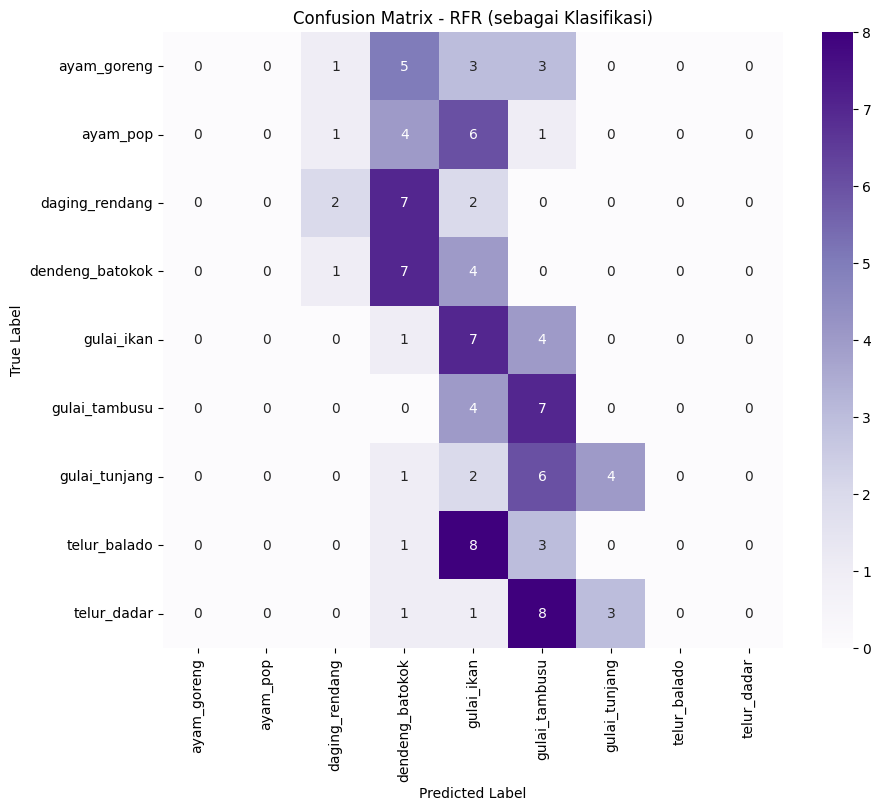

Confusion matrix disimpan: /content/drive/MyDrive/ProyekKlasifikasiViaRFR_ulang/results_cvr_rfr/confusion_matrix_rfr_clf_initial.png

--- Evaluasi Performa Regresi (Prediksi vs Target 0,1,2...) ---
  MSE:4.9497 | RMSE:2.2248 | MAE:1.7424 | R2:0.2722
(Metrik regresi ini BUKAN metrik klasifikasi akhir)

--- SECTION 7 Selesai ---


In [8]:
# ==============================================================================
# SECTION 7: EVALUASI MODEL RandomForestRegressor (SEBAGAI KLASIFIKASI)
# ==============================================================================
print("\n--- SECTION 7: Evaluasi RandomForestRegressor sebagai Klasifikasi ---")

if rfr_cvr_initial_model and X_test_scaled.size > 0 and y_test_clf_num.size > 0 and le_cvr:
    try:
        print("Memprediksi nilai kontinu pada data test...")
        y_pred_continuous_rfr = rfr_cvr_initial_model.predict(X_test_scaled)

        # --- Konversi Prediksi Kontinu ke Label Kelas ---
        print("Mengkonversi prediksi kontinu ke label kelas (pembulatan ke integer terdekat)...")
        y_pred_labels_rfr = np.round(y_pred_continuous_rfr).astype(int)
        min_class_idx = 0
        max_class_idx = len(le_cvr.classes_) - 1
        y_pred_labels_rfr = np.clip(y_pred_labels_rfr, min_class_idx, max_class_idx)

        # --- Evaluasi sebagai Klasifikasi ---
        print("\n--- Evaluasi Performa Klasifikasi ---")
        accuracy_rfr_clf = accuracy_score(y_test_clf_num, y_pred_labels_rfr)
        print(f"Akurasi Klasifikasi (setelah pembulatan): {accuracy_rfr_clf:.4f}")
        print("\nLaporan Klasifikasi:")
        class_names_report_cvr = [str(cn) for cn in le_cvr.classes_]
        print(classification_report(y_test_clf_num, y_pred_labels_rfr, target_names=class_names_report_cvr, zero_division=0))
        cm_rfr_clf = confusion_matrix(y_test_clf_num, y_pred_labels_rfr, labels=le_cvr.transform(le_cvr.classes_))
        plt.figure(figsize=(10, 8)); sns.heatmap(cm_rfr_clf, annot=True, fmt='d', cmap='Purples', xticklabels=class_names_report_cvr, yticklabels=class_names_report_cvr)
        plt.title('Confusion Matrix - RFR (sebagai Klasifikasi)'); plt.xlabel('Predicted Label'); plt.ylabel('True Label')
        cm_path_rfr_clf = os.path.join(RESULTS_PATH, "confusion_matrix_rfr_clf_initial.png"); plt.savefig(cm_path_rfr_clf); plt.show()
        print(f"Confusion matrix disimpan: {cm_path_rfr_clf}")

        # --- Evaluasi sebagai Regresi (Opsional, untuk pemahaman) ---
        print("\n--- Evaluasi Performa Regresi (Prediksi vs Target 0,1,2...) ---")
        mse_rfr_reg = mean_squared_error(y_test_clf_num, y_pred_continuous_rfr); rmse_rfr_reg = np.sqrt(mse_rfr_reg)
        mae_rfr_reg = mean_absolute_error(y_test_clf_num, y_pred_continuous_rfr); r2_rfr_reg = r2_score(y_test_clf_num, y_pred_continuous_rfr)
        print(f"  MSE:{mse_rfr_reg:.4f} | RMSE:{rmse_rfr_reg:.4f} | MAE:{mae_rfr_reg:.4f} | R2:{r2_rfr_reg:.4f}")
        print("(Metrik regresi ini BUKAN metrik klasifikasi akhir)")

    except Exception as e: print(f"Error evaluasi RFR: {e}"); import traceback; traceback.print_exc()
else: print("Model RFR awal tidak terlatih atau tidak ada data test.")
print("\n--- SECTION 7 Selesai ---")

In [14]:
# ==============================================================================
# SECTION 8: FINE-TUNING RandomForestRegressor (Target: Label Numerik) dengan Progress Bar
# ==============================================================================
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from sklearn.model_selection import ParameterGrid

print("\n--- SECTION 8: Fine-Tuning RandomForestRegressor (Target: Label Numerik) ---")
rfr_cvr_tuned_model = None
best_params_rfr_cvr = None

if X_train_scaled.size > 0 and y_train_clf_num.size > 0:
    try:
        # Grid parameter untuk RFR
        param_grid_rfr_cvr = {
            'n_estimators': [50, 150],
            'max_depth': [10, 20, None],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [3, 5]
        }

        # Inisialisasi GridSearchCV: parallelisme di level CV, tree-building serial
        grid_search_rfr_cvr = GridSearchCV(
            RandomForestRegressor(random_state=42, n_jobs=1),  # n_jobs=1 agar hanya satu fit per tugas
            param_grid_rfr_cvr,
            cv=2,
            scoring='neg_mean_squared_error',
            verbose=0,
            n_jobs=-1  # n_jobs -1 untuk parallel CV folds
        )

        # Hitung total iterasi (jumlah kombinasi * jumlah fold)
        param_list = list(ParameterGrid(param_grid_rfr_cvr))
        total_jobs = len(param_list) * grid_search_rfr_cvr.cv
        print(f"Menjalankan GridSearchCV dengan total iterasi: {total_jobs}")

        # Eksekusi fit dengan progress bar
        with tqdm_joblib(tqdm(desc="GridSearchCV RFR", total=total_jobs)):
            start_time_grid_rfr = time.time()
            grid_search_rfr_cvr.fit(X_train_scaled, y_train_clf_num)
            end_time_grid_rfr = time.time()

        print(f"GridSearchCV selesai dalam {end_time_grid_rfr - start_time_grid_rfr:.2f} detik.")

        # Simpan hasil terbaik
        best_params_rfr_cvr = grid_search_rfr_cvr.best_params_
        print(f"Parameter terbaik (berdasarkan Neg MSE): {best_params_rfr_cvr}")
        print(f"Skor CV terbaik (Neg MSE): {grid_search_rfr_cvr.best_score_:.4f}")
        rfr_cvr_tuned_model = grid_search_rfr_cvr.best_estimator_
        print("Model RandomForestRegressor di-fine-tune (sebagai regressor).")

        tuned_model_filename_rfr = os.path.join(MODEL_PATH, "rfr_cvr_tuned_model_ulang.joblib")
        joblib.dump(rfr_cvr_tuned_model, tuned_model_filename_rfr)
        print(f"Model RFR tuned disimpan: {tuned_model_filename_rfr}")

    except Exception as e:
        print(f"Error fine-tuning RFR: {e}"); import traceback; traceback.print_exc()
else:
    print("Tidak ada data training untuk fine-tuning.")

print("\n--- SECTION 8 Selesai ---")


--- SECTION 8: Fine-Tuning RandomForestRegressor (Target: Label Numerik) ---
Menjalankan GridSearchCV dengan total iterasi: 48


GridSearchCV RFR:   0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

GridSearchCV selesai dalam 2577.94 detik.
Parameter terbaik (berdasarkan Neg MSE): {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}
Skor CV terbaik (Neg MSE): -21.8494
Model RandomForestRegressor di-fine-tune (sebagai regressor).
Model RFR tuned disimpan: /content/drive/MyDrive/ProyekKlasifikasiViaRFR_ulang/models_cvr_rfr/rfr_cvr_tuned_model_ulang.joblib

--- SECTION 8 Selesai ---


GridSearchCV RFR:   0%|          | 0/48 [49:03<?, ?it/s]


--- SECTION 9: Evaluasi RFR Tuned sebagai Klasifikasi ---
Memprediksi nilai kontinu (tuned) pada data test...
Mengkonversi prediksi kontinu (tuned) ke label kelas...

--- Evaluasi Performa Klasifikasi (Tuned) ---
Akurasi Klasifikasi Tuned (setelah pembulatan): 0.2500

Laporan Klasifikasi (Tuned):
                 precision    recall  f1-score   support

    ayam_goreng       0.00      0.00      0.00        12
       ayam_pop       0.00      0.00      0.00        12
 daging_rendang       0.40      0.18      0.25        11
dendeng_batokok       0.26      0.58      0.36        12
     gulai_ikan       0.18      0.50      0.26        12
  gulai_tambusu       0.20      0.64      0.30        11
  gulai_tunjang       0.71      0.38      0.50        13
   telur_balado       0.00      0.00      0.00        12
    telur_dadar       0.00      0.00      0.00        13

       accuracy                           0.25       108
      macro avg       0.19      0.25      0.19       108
   weighted avg

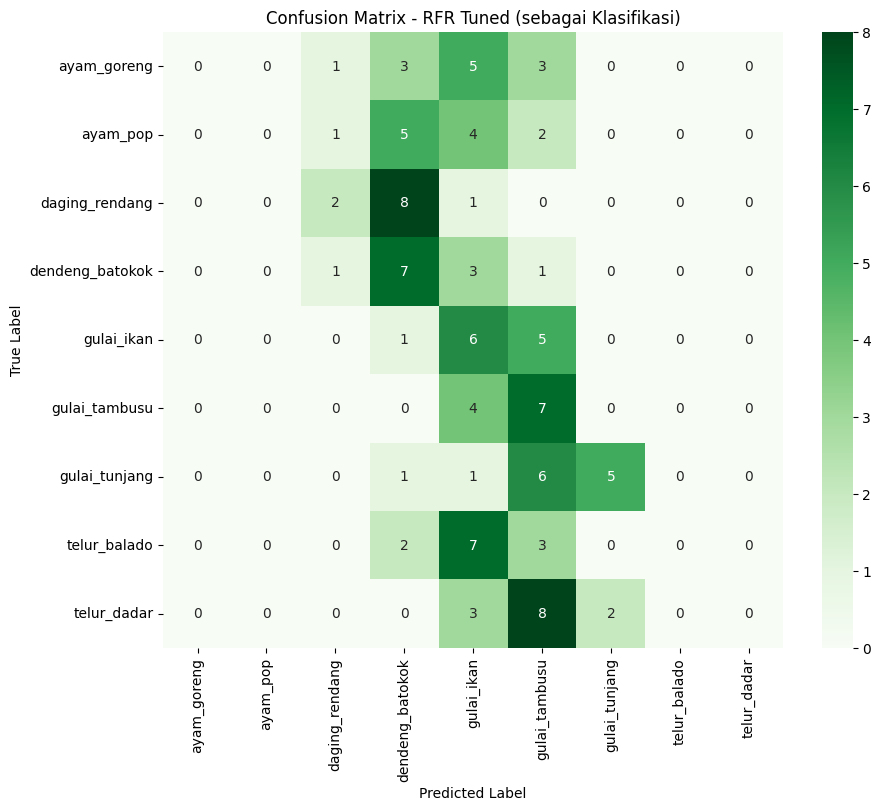

Confusion matrix (tuned) disimpan: /content/drive/MyDrive/ProyekKlasifikasiViaRFR_ulang/results_cvr_rfr/confusion_matrix_rfr_clf_tuned.png

--- Evaluasi Performa Regresi (Tuned) (Prediksi vs Target 0,1,2...) ---
  MSE:5.0678 | RMSE:2.2512 | MAE:1.7765 | R2:0.2549

--- SECTION 9 Selesai ---


In [15]:
# ==============================================================================
# SECTION 9: EVALUASI MODEL RandomForestRegressor TUNED (SEBAGAI KLASIFIKASI)
# ==============================================================================
print("\n--- SECTION 9: Evaluasi RFR Tuned sebagai Klasifikasi ---")

if rfr_cvr_tuned_model and X_test_scaled.size > 0 and y_test_clf_num.size > 0 and le_cvr:
    try:
        print("Memprediksi nilai kontinu (tuned) pada data test...")
        y_pred_continuous_rfr_tuned = rfr_cvr_tuned_model.predict(X_test_scaled)
        print("Mengkonversi prediksi kontinu (tuned) ke label kelas...")
        y_pred_labels_rfr_tuned = np.round(y_pred_continuous_rfr_tuned).astype(int)
        y_pred_labels_rfr_tuned = np.clip(y_pred_labels_rfr_tuned, min_class_idx, max_class_idx)

        print("\n--- Evaluasi Performa Klasifikasi (Tuned) ---")
        accuracy_rfr_clf_tuned = accuracy_score(y_test_clf_num, y_pred_labels_rfr_tuned)
        print(f"Akurasi Klasifikasi Tuned (setelah pembulatan): {accuracy_rfr_clf_tuned:.4f}")
        print("\nLaporan Klasifikasi (Tuned):")
        print(classification_report(y_test_clf_num, y_pred_labels_rfr_tuned, target_names=class_names_report_cvr, zero_division=0))
        cm_rfr_clf_tuned = confusion_matrix(y_test_clf_num, y_pred_labels_rfr_tuned, labels=le_cvr.transform(le_cvr.classes_))
        plt.figure(figsize=(10, 8)); sns.heatmap(cm_rfr_clf_tuned, annot=True, fmt='d', cmap='Greens', xticklabels=class_names_report_cvr, yticklabels=class_names_report_cvr)
        plt.title('Confusion Matrix - RFR Tuned (sebagai Klasifikasi)'); plt.xlabel('Predicted Label'); plt.ylabel('True Label')
        cm_path_rfr_clf_tuned = os.path.join(RESULTS_PATH, "confusion_matrix_rfr_clf_tuned.png"); plt.savefig(cm_path_rfr_clf_tuned); plt.show()
        print(f"Confusion matrix (tuned) disimpan: {cm_path_rfr_clf_tuned}")

        # --- Evaluasi sebagai Regresi (Tuned) ---
        print("\n--- Evaluasi Performa Regresi (Tuned) (Prediksi vs Target 0,1,2...) ---")
        mse_rfr_reg_tuned = mean_squared_error(y_test_clf_num, y_pred_continuous_rfr_tuned); rmse_rfr_reg_tuned = np.sqrt(mse_rfr_reg_tuned)
        mae_rfr_reg_tuned = mean_absolute_error(y_test_clf_num, y_pred_continuous_rfr_tuned); r2_rfr_reg_tuned = r2_score(y_test_clf_num, y_pred_continuous_rfr_tuned)
        print(f"  MSE:{mse_rfr_reg_tuned:.4f} | RMSE:{rmse_rfr_reg_tuned:.4f} | MAE:{mae_rfr_reg_tuned:.4f} | R2:{r2_rfr_reg_tuned:.4f}")

    except Exception as e: print(f"Error evaluasi RFR tuned: {e}"); import traceback; traceback.print_exc()
elif not rfr_cvr_tuned_model: print("Model RFR tuned tidak tersedia.")
else: print("Data test tidak tersedia untuk evaluasi.")
print("\n--- SECTION 9 Selesai ---")


--- SECTION 10: Inferensi dengan RandomForestRegressor (Output dibulatkan) ---
Menggunakan model RFR hasil fine-tuning untuk inferensi.

Melakukan inferensi pada gambar contoh: /content/drive/MyDrive/ProyekKlasifikasiViaRFR_ulang/datasets_cvr_rfr/processed_cvr_rfr/split_data_cvr_rfr_ulang/test/ayam_goreng/ayam_goreng (91).jpg


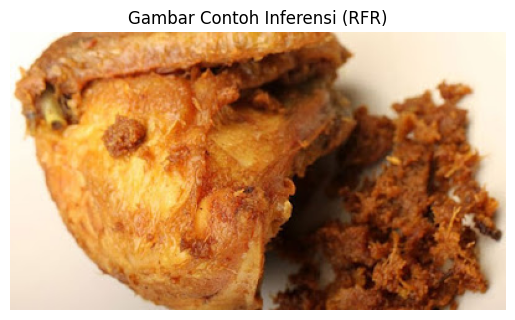

  Prediksi Nilai Kontinu (sebelum dibulatkan): 4.0301
  Prediksi Kelas Akhir (setelah pembulatan): gulai_ikan

--- SEMUA PROSES KLASIFIKASI VIA RandomForestRegressor SELESAI ---


In [16]:
# ==============================================================================
# SECTION 10: INFERENCE (RandomForestRegressor UNTUK 'KLASIFIKASI')
# ==============================================================================
print("\n--- SECTION 10: Inferensi dengan RandomForestRegressor (Output dibulatkan) ---")

final_rfr_cvr_model = None
# Pilih model terbaik (tuned jika ada, jika tidak, gunakan initial)
if rfr_cvr_tuned_model:
    final_rfr_cvr_model = rfr_cvr_tuned_model
    print("Menggunakan model RFR hasil fine-tuning untuk inferensi.")
elif rfr_cvr_initial_model:
    final_rfr_cvr_model = rfr_cvr_initial_model
    print("Menggunakan model RFR awal untuk inferensi.")
else:
    print("Tidak ada model RFR yang tersedia untuk inferensi.")

if final_rfr_cvr_model and scaler_cvr and le_cvr: # scaler_cvr dari Section 4
    def preprocess_single_image_for_rfr_cvr_inference(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
        try:
            img = Image.open(image_path).convert('L').resize(target_size)
            flattened_img = np.array(img).flatten().reshape(1, -1)
            scaled_img = scaler_cvr.transform(flattened_img.astype(np.float32))
            return scaled_img
        except Exception as e: print(f"Error preprocessing inferensi: {e}"); return None

    def predict_image_class_via_rfr(image_path, model, label_encoder):
        processed_image = preprocess_single_image_for_rfr_cvr_inference(image_path)
        if processed_image is not None:
            try:
                predicted_continuous = model.predict(processed_image)[0] # Hasilnya angka kontinu
                # Bulatkan dan klip ke rentang indeks kelas yang valid
                min_idx, max_idx = 0, len(label_encoder.classes_) - 1
                predicted_label_index = np.clip(np.round(predicted_continuous).astype(int), min_idx, max_idx)
                predicted_class_name = label_encoder.inverse_transform([predicted_label_index])[0]
                return predicted_class_name, predicted_continuous # Kembalikan juga nilai kontinu sblm dibulatkan
            except Exception as e_predict: print(f"Error saat prediksi: {e_predict}"); return None, None
        return None, None

    # Contoh inferensi
    example_image_path_cvr_rfr = None
    if SPLIT_OUTPUT_PATH_CVR and os.path.exists(os.path.join(SPLIT_OUTPUT_PATH_CVR, "test")):
        try: # Ambil contoh gambar
            test_folder = os.path.join(SPLIT_OUTPUT_PATH_CVR, "test")
            first_class_folder_name = sorted(os.listdir(test_folder))[0]
            first_class_folder = os.path.join(test_folder, first_class_folder_name)
            if os.path.isdir(first_class_folder) and len(os.listdir(first_class_folder)) > 0:
                 example_image_name = os.listdir(first_class_folder)[0]
                 example_image_path_cvr_rfr = os.path.join(first_class_folder, example_image_name)
        except Exception as e_ex: print(f"Tidak bisa mendapatkan contoh gambar: {e_ex}")

    if example_image_path_cvr_rfr and os.path.exists(example_image_path_cvr_rfr):
        print(f"\nMelakukan inferensi pada gambar contoh: {example_image_path_cvr_rfr}")
        try:
            img_display = Image.open(example_image_path_cvr_rfr)
            plt.imshow(img_display); plt.title("Gambar Contoh Inferensi (RFR)"); plt.axis('off'); plt.show()

            predicted_class, predicted_cont_val = predict_image_class_via_rfr(example_image_path_cvr_rfr, final_rfr_cvr_model, le_cvr)
            if predicted_class:
                print(f"  Prediksi Nilai Kontinu (sebelum dibulatkan): {predicted_cont_val:.4f}")
                print(f"  Prediksi Kelas Akhir (setelah pembulatan): {predicted_class}")
            else: print("  Gagal melakukan prediksi.")
        except Exception as e_inf: print(f"Error saat inferensi: {e_inf}")
    else: print("Tidak ada gambar contoh valid untuk inferensi.")
else:
    if not final_rfr_cvr_model: print("Model RFR tidak tersedia.")
    if not scaler_cvr: print("Scaler tidak tersedia.")
    if not le_cvr: print("LabelEncoder tidak tersedia.")

print("\n--- SEMUA PROSES KLASIFIKASI VIA RandomForestRegressor SELESAI ---")